# Fine-tuning a model on a Q&A task using SQUAD

## In this notebook, we will see how to fine-tune one of the [🤗 Transformers](https://github.com/huggingface/transformers) model to a question answering task, which is the task of extracting the answer to a question from a given context. We will see how to easily load a dataset for these kinds of tasks and use the `Trainer` API to fine-tune a model on it.

![Widget inference representing the QA task](images/question_answering.png)

**Note:** This notebook finetunes models that answer question by taking a substring of a context, not by generating new text.

Make sure your version of Transformers is at least 4.8.1 since the functionality was introduced in that version:

In [1]:
import transformers

print(transformers.__version__)

4.9.2


This notebook is built to run on any question answering task with the same format as SQUAD (version 1 or 2), with any model checkpoint from the [Model Hub](https://huggingface.co/models) as long as that model has a version with a token classification head and a fast tokenizer (check on [this table](https://huggingface.co/transformers/index.html#bigtable) if this is the case). It might just need some small adjustments if you decide to use a different dataset than the one used here. Depending on you model and the GPU you are using, you might need to adjust the batch size to avoid out-of-memory errors. Set those three parameters, then the rest of the notebook should run smoothly:

In [2]:
# This flag is the difference between SQUAD v1 or 2 (if you're using another dataset, it indicates if impossible
# answers are allowed or not).
squad_v2 = False
model_checkpoint ="distilbert-base-uncased"

## Loading the dataset

We will use the [🤗 Datasets](https://github.com/huggingface/datasets) library to download the data and get the metric we need to use for evaluation (to compare our model to the benchmark). This can be easily done with the functions `load_dataset` and `load_metric`.  

In [3]:
from datasets import load_dataset, load_metric

For our example here, we'll use the [SQUAD dataset](https://rajpurkar.github.io/SQuAD-explorer/). The notebook should work with any question answering dataset provided by the 🤗 Datasets library. If you're using your own dataset defined from a JSON or csv file (see the [Datasets documentation](https://huggingface.co/docs/datasets/loading_datasets.html#from-local-files) on how to load them), it might need some adjustments in the names of the columns used.

In [4]:
datasets = load_dataset("squad_v2" if squad_v2 else "squad")

Reusing dataset squad (/home/john/.cache/huggingface/datasets/squad/plain_text/1.0.0/d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453)


The `datasets` object itself is [`DatasetDict`](https://huggingface.co/docs/datasets/package_reference/main_classes.html#datasetdict), which contains one key for the training, validation and test set.

In [5]:
datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 87599
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 10570
    })
})

We can see the training, validation and test sets all have a column for the context, the question and the answers to those questions.

To access an actual element, you need to select a split first, then give an index:

In [6]:
datasets["train"][0]

{'id': '5733be284776f41900661182',
 'title': 'University_of_Notre_Dame',
 'context': 'Architecturally, the school has a Catholic character. Atop the Main Building\'s gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.',
 'question': 'To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?',
 'answers': {'text': ['Saint Bernadette Soubirous'], 'answer_start': [515]}}

We can see the answers are indicated by their start position in the text (here at character 515) and their full text, which is a substring of the context as we mentioned above.

To get a sense of what the data looks like, the following function will show some examples picked randomly in the dataset (automatically decoding the labels in passing).

In [7]:
from datasets import ClassLabel, Sequence
import random
import pandas as pd
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=5):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)
    
    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
        elif isinstance(typ, Sequence) and isinstance(typ.feature, ClassLabel):
            df[column] = df[column].transform(lambda x: [typ.feature.names[i] for i in x])
    display(HTML(df.to_html()))

In [8]:
show_random_elements(datasets["train"])

,id,title,context,question,answers
0,56e7ca0937bdd419002c4400,Tristan_da_Cunha,"On November 2011, the sailing boat Puma's Mar Mostro participant in Volvo Ocean Race arrived to the island after her mast broke in the first leg from Alicante and Cape Town. This event made the island, its inhabitants and lifestyle known worldwide thanks to the media reports.",When did a boat arrive at the island with damage during a race?,"{'text': ['November 2011'], 'answer_start': [3]}"
1,572f703ca23a5019007fc629,Database,"Linking the information back together is the key to this system. In the relational model, some bit of information was used as a ""key"", uniquely defining a particular record. When information was being collected about a user, information stored in the optional tables would be found by searching for this key. For instance, if the login name of a user is unique, addresses and phone numbers for that user would be recorded with the login name as its key. This simple ""re-linking"" of related data back into a single collection is something that traditional computer languages are not designed for.",How is information accessed in a relational model?,"{'text': ['a ""key""'], 'answer_start': [126]}"
2,5727f05aff5b5019007d98ee,USB,"The OTG device with the A-plug inserted is called the A-device and is responsible for powering the USB interface when required and by default assumes the role of host. The OTG device with the B-plug inserted is called the B-device and by default assumes the role of peripheral. An OTG device with no plug inserted defaults to acting as a B-device. If an application on the B-device requires the role of host, then the Host Negotiation Protocol (HNP) is used to temporarily transfer the host role to the B-device.",What is the A-device responsible for?,"{'text': ['powering the USB interface when required'], 'answer_start': [86]}"
3,57269a18dd62a815002e8aca,Napoleon,"After Austerlitz, Napoleon established the Confederation of the Rhine in 1806. A collection of German states intended to serve as a buffer zone between France and Central Europe, the creation of the Confederation spelled the end of the Holy Roman Empire and significantly alarmed the Prussians. The brazen reorganization of German territory by the French risked threatening Prussian influence in the region, if not eliminating it outright. War fever in Berlin rose steadily throughout the summer of 1806. At the insistence of his court, especially his wife Queen Louise, Frederick William III decided to challenge the French domination of Central Europe by going to war.",What other royal figure strongly influenced Frederick William III's decision to go to war with France?,"{'text': ['Queen Louise'], 'answer_start': [557]}"
4,56cd8d2762d2951400fa66df,Sino-Tibetan_relations_during_the_Ming_dynasty,"Van Praag states that the Ming court established diplomatic delegations with Tibet merely to secure urgently needed horses. Wang and Nyima argue that these were not diplomatic delegations at all, that Tibetan areas were ruled by the Ming since Tibetan leaders were granted positions as Ming officials, that horses were collected from Tibet as a mandatory ""corvée"" tax, and therefore Tibetans were ""undertaking domestic affairs, not foreign diplomacy"". Sperling writes that the Ming simultaneously bought horses in the Kham region while fighting Tibetan tribes in Amdo and receiving Tibetan embassies in Nanjing. He also argues that the embassies of Tibetan lamas visiting the Ming court were for the most part efforts to promote commercial transactions between the lamas' large, wealthy entourage and Ming Chinese merchants and officials. Kolmaš writes that while the Ming maintained a laissez-faire policy towards Tibet and limited the numbers of the Tibetan retinues, the Tibetans sought to maintain a tributary relationship with the Ming because imperial patronage provided them with wealth and power. Laird writes that Tibetans eagerly sought Ming court invitations since the gif

## Preprocessing the training data

Before we can feed those texts to our model, we need to preprocess them. This is done by a 🤗 Transformers `Tokenizer` which will (as the name indicates) tokenize the inputs (including converting the tokens to their corresponding IDs in the pretrained vocabulary) and put it in a format the model expects, as well as generate the other inputs that model requires.

To do all of this, we instantiate our tokenizer with the `AutoTokenizer.from_pretrained` method, which will ensure:

- we get a tokenizer that corresponds to the model architecture we want to use,
- we download the vocabulary used when pretraining this specific checkpoint.

That vocabulary will be cached, so it's not downloaded again the next time we run the cell.

In [9]:
from transformers import AutoTokenizer
    
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

The following assertion ensures that our tokenizer is a fast tokenizers (backed by Rust) from the 🤗 Tokenizers library. Those fast tokenizers are available for almost all models, and we will need some of the special features they have for our preprocessing.

In [10]:
import transformers
assert isinstance(tokenizer, transformers.PreTrainedTokenizerFast)

You can check which type of models have a fast tokenizer available and which don't on the [big table of models](https://huggingface.co/transformers/index.html#bigtable).

You can directly call this tokenizer on two sentences (one for the answer, one for the context):

In [11]:
tokenizer("What is your name?", "My name is Sylvain.")

{'input_ids': [101, 2054, 2003, 2115, 2171, 1029, 102, 2026, 2171, 2003, 25353, 22144, 2378, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

Depending on the model you selected, you will see different keys in the dictionary returned by the cell above. They don't matter much for what we're doing here (just know they are required by the model we will instantiate later), you can learn more about them in [this tutorial](https://huggingface.co/transformers/preprocessing.html) if you're interested.

Now one specific thing for the preprocessing in question answering is how to deal with very long documents. We usually truncate them in other tasks, when they are longer than the model maximum sentence length, but here, removing part of the the context might result in losing the answer we are looking for. To deal with this, we will allow one (long) example in our dataset to give several input features, each of length shorter than the maximum length of the model (or the one we set as a hyper-parameter). Also, just in case the answer lies at the point we split a long context, we allow some overlap between the features we generate controlled by the hyper-parameter `doc_stride`:

In [12]:
max_length = 384 # The maximum length of a feature (question and context)
doc_stride = 128 # The authorized overlap between two part of the context when splitting it is needed.

Let's find one long example in our dataset:

In [13]:
for i, example in enumerate(datasets["train"]):
    if len(tokenizer(example["question"], example["context"])["input_ids"]) > max_length:
        break
print(f"index {i} will span multiple features.\n\n sample = {datasets['train'][i]} ")

index 249 will span multiple features.

 sample = {'id': '5733caf74776f4190066124c', 'title': 'University_of_Notre_Dame', 'context': "The men's basketball team has over 1,600 wins, one of only 12 schools who have reached that mark, and have appeared in 28 NCAA tournaments. Former player Austin Carr holds the record for most points scored in a single game of the tournament with 61. Although the team has never won the NCAA Tournament, they were named by the Helms Athletic Foundation as national champions twice. The team has orchestrated a number of upsets of number one ranked teams, the most notable of which was ending UCLA's record 88-game winning streak in 1974. The team has beaten an additional eight number-one teams, and those nine wins rank second, to UCLA's 10, all-time in wins against the top team. The team plays in newly renovated Purcell Pavilion (within the Edmund P. Joyce Center), which reopened for the beginning of the 2009–2010 season. The team is coached by Mike Brey, who, 

Without any truncation, we get the following length for the input IDs:

In [14]:
len(tokenizer(example["question"], example["context"])["input_ids"])

396

Now, if we just truncate, we will lose information (and possibly the answer to our question):

In [15]:
len(tokenizer(example["question"], example["context"], max_length=max_length, truncation="only_second")["input_ids"])

384

Note that we never want to truncate the question, only the context, else the `only_second` truncation picked. Now, our tokenizer can automatically return us a list of features capped by a certain maximum length, with the overlap we talked above, we just have to tell it with `return_overflowing_tokens=True` and by passing the stride:

In [16]:
tokenized_example = tokenizer(
    example["question"],
    example["context"],
    max_length=max_length,
    truncation="only_second",
    return_overflowing_tokens=True,
    stride=doc_stride
)

In [17]:
len(tokenized_example['input_ids'][0])

384

Now we don't have one list of `input_ids`, but several: 

In [18]:
[len(x) for x in tokenized_example["input_ids"]]

[384, 157]

And if we decode them, we can see the overlap:

In [19]:
for x in tokenized_example["input_ids"][:2]:
    print(f"{tokenizer.decode(x)}\n" )

[CLS] how many wins does the notre dame men's basketball team have? [SEP] the men's basketball team has over 1, 600 wins, one of only 12 schools who have reached that mark, and have appeared in 28 ncaa tournaments. former player austin carr holds the record for most points scored in a single game of the tournament with 61. although the team has never won the ncaa tournament, they were named by the helms athletic foundation as national champions twice. the team has orchestrated a number of upsets of number one ranked teams, the most notable of which was ending ucla's record 88 - game winning streak in 1974. the team has beaten an additional eight number - one teams, and those nine wins rank second, to ucla's 10, all - time in wins against the top team. the team plays in newly renovated purcell pavilion ( within the edmund p. joyce center ), which reopened for the beginning of the 2009 – 2010 season. the team is coached by mike brey, who, as of the 2014 – 15 season, his fifteenth at notr

Now this will give us some work to properly treat the answers: we need to find in which of those features the answer actually is, and where exactly in that feature. The models we will use require the start and end positions of these answers in the tokens, so we will also need to to map parts of the original context to some tokens. Thankfully, the tokenizer we're using can help us with that by returning an `offset_mapping`:

In [20]:
tokenized_example = tokenizer(
    example["question"],
    example["context"],
    max_length=max_length,
    truncation="only_second",
    return_overflowing_tokens=True,
    return_offsets_mapping=True,
    stride=doc_stride
)
print(tokenized_example["offset_mapping"][0][:100])

[(0, 0), (0, 3), (4, 8), (9, 13), (14, 18), (19, 22), (23, 28), (29, 33), (34, 37), (37, 38), (38, 39), (40, 50), (51, 55), (56, 60), (60, 61), (0, 0), (0, 3), (4, 7), (7, 8), (8, 9), (10, 20), (21, 25), (26, 29), (30, 34), (35, 36), (36, 37), (37, 40), (41, 45), (45, 46), (47, 50), (51, 53), (54, 58), (59, 61), (62, 69), (70, 73), (74, 78), (79, 86), (87, 91), (92, 96), (96, 97), (98, 101), (102, 106), (107, 115), (116, 118), (119, 121), (122, 126), (127, 138), (138, 139), (140, 146), (147, 153), (154, 160), (161, 165), (166, 171), (172, 175), (176, 182), (183, 186), (187, 191), (192, 198), (199, 205), (206, 208), (209, 210), (211, 217), (218, 222), (223, 225), (226, 229), (230, 240), (241, 245), (246, 248), (248, 249), (250, 258), (259, 262), (263, 267), (268, 271), (272, 277), (278, 281), (282, 285), (286, 290), (291, 301), (301, 302), (303, 307), (308, 312), (313, 318), (319, 321), (322, 325), (326, 330), (330, 331), (332, 340), (341, 351), (352, 354), (355, 363), (364, 373), (374,

In [21]:
len(tokenized_example['offset_mapping'][1])

157

This gives, for each index of our input IDS, the corresponding start and end character in the original text that gave our token. The very first token (`[CLS]`) has (0, 0) because it doesn't correspond to any part of the question/answer, then the second token is the same as the characters 0 to 3 of the question:

In [22]:
first_token_id = tokenized_example["input_ids"][0][1]
offsets = tokenized_example["offset_mapping"][0][1]
print(tokenizer.convert_ids_to_tokens([first_token_id])[0], example["question"][offsets[0]:offsets[1]])

how How


So we can use this mapping to find the position of the start and end tokens of our answer in a given feature. We just have to distinguish which parts of the offsets correspond to the question and which part correspond to the context, this is where the `sequence_ids` method of our `tokenized_example` can be useful:

In [23]:
sequence_ids = tokenized_example.sequence_ids()
print(sequence_ids)

[None, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, None, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [24]:
answers = example["answers"]
answers

{'text': ['over 1,600'], 'answer_start': [30]}

### The start value in answer indicates the character offset within the context where the answer starts. We're trying to find the tuple offset of this character in the offset array, thus result of the offset tuple index is less than this value.  Also, we need to find tje feature that contains the full answer. 

In [25]:
ctx_start_index = 0
while sequence_ids[ctx_start_index] != 1:
    ctx_start_index += 1
print(f'context starts at index {ctx_start_index} in sequence_ids')        

context starts at index 16 in sequence_ids


It returns `None` for the special tokens, then 0 or 1 depending on whether the corresponding token comes from the first sentence past (the question) or the second (the context). Now with all of this, we can find the first and last token of the answer in one of our input feature (or if the answer is not in this feature):

In [26]:
answers = example["answers"]
start_char = answers["answer_start"][0]
end_char = start_char + len(answers["text"][0])
print(f'start_char= {start_char} \n end_char={end_char} ')

# find start of context in sequence_ids which is first occurance of 1.
ctx_start = 0
while sequence_ids[ctx_start] != 1:
    ctx_start += 1

# End token index of the current span in the text.
ctx_end = len(tokenized_example["input_ids"][0]) - 1
while sequence_ids[ctx_end] != 1:
    ctx_end -= 1

print(f'context range in sequence: {ctx_start} ~ {ctx_end} ')

# Detect if the answer is out of the span (in which case this feature is labeled with the CLS index).
offsets = tokenized_example["offset_mapping"][0]
if (offsets[ctx_start][0] <= start_char and offsets[ctx_end][1] >= end_char):
    # Move the token_start_index and token_end_index to the two ends of the answer.
    # Note: we could go after the last offset if the answer is the last word (edge case).
    while ctx_start < len(offsets) and offsets[ctx_start][0] <= start_char:
        ctx_start += 1
    start_position = ctx_start - 1
    
    while offsets[ctx_end][1] >= end_char:
        ctx_end -= 1
    end_position = ctx_end + 1
    #found answer within context in current feature
    print(f'answer from {start_position} ~ {end_position}') 
else:
    print("The answer is not in this feature.")

start_char= 30 
 end_char=40 
context range in sequence: 16 ~ 382 
answer from 23 ~ 26


And we can double check that it is indeed the theoretical answer:

In [27]:
print(tokenizer.decode(tokenized_example["input_ids"][0][start_position: end_position+1]))
print(answers["text"][0])

over 1, 600
over 1,600


Now let's put everything together in one function we will apply to our training set. In the case of impossible answers (the answer is in another feature given by an example with a long context), we set the cls index for both the start and end position. We could also simply discard those examples from the training set if the flag `allow_impossible_answers` is `False`. Since the preprocessing is already complex enough as it is, we've kept is simple for this part.

In [28]:
import numpy as np

def prepare_train_features(examples):
    # Some of the questions have lots of whitespace on the left, which is not useful and will make the
    # truncation of the context fail (the tokenized question will take a lots of space). So we remove that
    # left whitespace
    examples["question"] = [q.lstrip() for q in examples["question"]]

    # Tokenize our examples with truncation and padding, but keep the overflows using a stride. This results
    # in one example possibly giving several features when a context is long, each of those features having a
    # context that overlaps a bit the context of the previous feature.
    tokenized_examples = tokenizer(examples["question"], examples["context"],
                                   truncation="only_second", max_length=max_length,
                                   stride=doc_stride, return_overflowing_tokens=True,
                                   return_offsets_mapping=True, padding="max_length")        

    # print(f'tokenized_examples has keys: {tokenized_examples.keys()}')
    
    # Since one example might give us several features if it has a long context, we need a map from a feature to
    # its corresponding example. This key gives us just that.
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")
    
    # The offset mappings will give us a map from token to character position in the original context. This will
    # help us compute the start_positions and end_positions.
    # offset_mapping has shape [number of features][max_length][2] where last dim is tuple
    offset_mapping = tokenized_examples.pop("offset_mapping")
    
    # print(f"sample_mapping={sample_mapping}, offset_mapping's shape shape={np.array(offset_mapping).shape}")
        
    # add 2 keys to the tokenized_examples dict indicating the answer's positions within
    # the feature spans. 
    tokenized_examples["start_positions"] = []
    tokenized_examples["end_positions"] = []

    for i, offsets in enumerate(offset_mapping):        
        # We will label impossible answers with the index of the CLS token.
        input_ids = tokenized_examples["input_ids"][i]
        cls_index = input_ids.index(tokenizer.cls_token_id)

        # Grab the sequence corresponding to that example (to know what is the context and what is the question).
        sequence_ids = tokenized_examples.sequence_ids(i)

        # One example can give several spans, this is the index of the example containing this span of text.
        sample_index = sample_mapping[i]
        answers = examples["answers"][sample_index] # get the answer for this sample
        # If no answers are given, set the cls_index as answer.
        if len(answers["answer_start"]) == 0:
            tokenized_examples["start_positions"].append(cls_index)
            tokenized_examples["end_positions"].append(cls_index)
        else:
            # Start/end character index of the answer in the text.
            start_char = answers["answer_start"][0]
            end_char = start_char + len(answers["text"][0])

            # Start token index of the current span in the text.
            ctx_start = 0
            while sequence_ids[ctx_start] != 1:
                ctx_start += 1

            # End token index of the current span in the text.
            ctx_end = len(input_ids) - 1
            while sequence_ids[ctx_end] != 1:
                ctx_end -= 1

            # Detect if the answer is out of the span (in which case this feature is labeled with the CLS index).
            if not (offsets[ctx_start][0] <= start_char and offsets[ctx_end][1] >= end_char):
                tokenized_examples["start_positions"].append(cls_index)
                tokenized_examples["end_positions"].append(cls_index)
            else:
                # Otherwise move the token_start_index and token_end_index to the two ends of the answer.
                # Note: we could go after the last offset if the answer is the last word (edge case).
                while ctx_start < len(offsets) and offsets[ctx_start][0] <= start_char:
                    ctx_start += 1 # find the tuple in offsets where 1st value is start_char position of answer
                tokenized_examples["start_positions"].append(ctx_start - 1)
                while offsets[ctx_end][1] >= end_char:
                    ctx_end -= 1
                tokenized_examples["end_positions"].append(ctx_end + 1)

    return tokenized_examples

This function works with one or several examples. In the case of several examples, the tokenizer will return a list of lists for each key:

In [29]:
features = prepare_train_features(datasets['train'][248:250])
print(f'returned feature has keys: {features.keys()} ')

returned feature has keys: dict_keys(['input_ids', 'attention_mask', 'start_positions', 'end_positions']) 


To apply this function on all the sentences (or pairs of sentences) in our dataset, we just use the `map` method of our `dataset` object we created earlier. This will apply the function on all the elements of all the splits in `dataset`, so our training, validation and testing data will be preprocessed in one single command. Since our preprocessing changes the number of samples, we need to remove the old columns when applying it.

In [30]:
print(f'before pre-processing, dataset:\n\n {datasets}')
tokenized_datasets = datasets.map(prepare_train_features, batched=True, remove_columns=datasets["train"].column_names)

before pre-processing, dataset:

 DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 87599
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 10570
    })
})


  0%|          | 0/88 [00:00<?, ?ba/s]

  0%|          | 0/11 [00:00<?, ?ba/s]

In [31]:
print(f'after pre-processing, tokenized dataset: \n\n {tokenized_datasets} ')

after pre-processing, tokenized dataset: 

 DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'end_positions', 'input_ids', 'start_positions'],
        num_rows: 88524
    })
    validation: Dataset({
        features: ['attention_mask', 'end_positions', 'input_ids', 'start_positions'],
        num_rows: 10784
    })
}) 


In [32]:
# tokenized_datasets.set_format("torch", columns=["input_ids", "attention_mask", "start_positions", "end_positions"])

Even better, the results are automatically cached by the 🤗 Datasets library to avoid spending time on this step the next time you run your notebook. The 🤗 Datasets library is normally smart enough to detect when the function you pass to map has changed (and thus requires to not use the cache data). For instance, it will properly detect if you change the task in the first cell and rerun the notebook. 🤗 Datasets warns you when it uses cached files, you can pass `load_from_cache_file=False` in the call to `map` to not use the cached files and force the preprocessing to be applied again.

Note that we passed `batched=True` to encode the texts by batches together. This is to leverage the full benefit of the fast tokenizer we loaded earlier, which will use multi-threading to treat the texts in a batch concurrently.

## Fine-tuning the model

Now that our data is ready for training, we can download the pretrained model and fine-tune it. Since our task is question answering, we use the `AutoModelForQuestionAnswering` class. Like with the tokenizer, the `from_pretrained` method will download and cache the model for us:

In [33]:
from transformers import AutoModelForQuestionAnswering

model = AutoModelForQuestionAnswering.from_pretrained(model_checkpoint)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForQuestionAnswering: ['vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this mode

The warning is telling us we are throwing away some weights (the `vocab_transform` and `vocab_layer_norm` layers) and randomly initializing some other (the `pre_classifier` and `classifier` layers). This is absolutely normal in this case, because we are removing the head used to pretrain the model on a masked language modeling objective and replacing it with a new head for which we don't have pretrained weights, so the library warns us we should fine-tune this model before using it for inference, which is exactly what we are going to do.

### hyper parameters

In [34]:
import math 

batch_size = 24
epochs=5
lr=1e-4
totalSteps=math.ceil(datasets['train'].num_rows/batch_size)*epochs

### Setup optimzzer and scheduler

In [35]:
from transformers import AdamW
from transformers import get_scheduler

opt=AdamW(model.parameters(), lr=lr)
scheduler = get_scheduler("cosine",optimizer=opt,num_warmup_steps=0,num_training_steps=totalSteps)

To instantiate a `Trainer`, we will need to define three more things. The most important is the [`TrainingArguments`](https://huggingface.co/transformers/main_classes/trainer.html#transformers.TrainingArguments), which is a class that contains all the attributes to customize the training. It requires one folder name, which will be used to save the checkpoints of the model, and all other arguments are optional:

Then we will need a data collator that will batch our processed examples together, here the default one will work:

In [36]:
from transformers import default_data_collator

data_collator = default_data_collator

We will evaluate our model and compute metrics in the next section (this is a very long operation, so we will only compute the evaluation loss during training).

Then we just need to pass all of this along with our datasets to the `Trainer`:

In [37]:
import torch 
from torch.utils.data import DataLoader

device=torch.device('cuda')
model.to(device)

DistilBertForQuestionAnswering(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            

In [38]:
train_dl=DataLoader(tokenized_datasets['train'],shuffle=True,  batch_size=batch_size, collate_fn=data_collator, pin_memory=True )
val_dl=DataLoader(tokenized_datasets['validation'], batch_size=batch_size, collate_fn=data_collator, pin_memory=True)

batch=next(iter(train_dl))
{key: val.shape for key, val in batch.items()}

{'attention_mask': torch.Size([24, 384]),
 'end_positions': torch.Size([24]),
 'input_ids': torch.Size([24, 384]),
 'start_positions': torch.Size([24])}

In [39]:
from tqdm import tqdm 

def train():
    model.train()    
    losses=0.
    
    for batch in tqdm(train_dl):
        opt.zero_grad()
        
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss=outputs[0]
        losses+=(loss.item()* len(batch['end_positions']))
        loss.backward()        
        opt.step()
        scheduler.step()
    return losses/tokenized_datasets['train'].num_rows                        

In [40]:
from tqdm import tqdm 

def evaluate():
    model.eval()
    losses=0.
    for batch in tqdm(val_dl):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss=outputs[0]
        losses+=(loss.item()* len(batch['end_positions']))
    return losses/tokenized_datasets['validation'].num_rows                        

In [41]:
import IPython.display as display 

def showResults(TLosses, VLosses):
    display.clear_output(wait=True)        
    print('epoch\t TrainLoss\t ValLoss')
    print("_________________________________________")
    i=1
    for tl, vl in zip(TLosses, VLosses) :
        print(f'{i}\t {tl:.3f}\t\t {vl:.3f}')
        i+=1

In [42]:
trainLosses=[]
valLosses=[]

for epoch in range(epochs):
    print(f'epoch: {epoch+1}/{epochs}\n training...')    
    losses=train()
    trainLosses.append(losses)
    print('evaluating...')
    losses=evaluate()    
    valLosses.append(losses)
    showResults(trainLosses, valLosses)
print('\n done...')

epoch	 TrainLoss	 ValLoss
_________________________________________
1	 1.483		 1.233
2	 0.917		 1.186
3	 0.562		 1.334
4	 0.308		 1.591
5	 0.183		 1.849

 done...


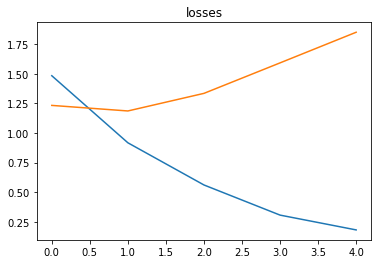

In [59]:
import matplotlib.pyplot as plt 

plt.title('losses')
plt.plot(trainLosses, label='t')
plt.plot(valLosses)
plt.show()

In [44]:
import os

model.save_pretrained('trained-QA-model')

## Inferencing

In [45]:
from transformers import AutoModelForQuestionAnswering, AutoTokenizer

QAmodel = AutoModelForQuestionAnswering.from_pretrained('trained-QA-model')
tokenizer=AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [46]:
import torch
device=torch.device('cuda')
QAmodel.to(device)

DistilBertForQuestionAnswering(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            

In [47]:
def readContent(filename):
    with open(filename) as f:
        ctx = f.read()
        return ctx 

In [48]:
content=readContent('content.txt')
len(content)

1464

In [49]:
def getAnswer(question):        
    tokens =tokenizer(question, content, add_special_tokens=True, return_tensors="pt").to(device=device)    
    ids = tokens["input_ids"].tolist()[0]            
    outputs=QAmodel(**tokens)    
    answer_start_scores = outputs.start_logits
    answer_end_scores = outputs.end_logits
    answer_start = torch.argmax(answer_start_scores)
    answer_end = torch.argmax(answer_end_scores) + 1  # Get the most likely end of answer with the argmax of the score
    answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(ids[answer_start:answer_end]))            
    return answer

In [50]:
str1="when was newton born"
str2="who invented calculus"
str3="what book did newton publish"
str4="when did newton publish his book"
str5="newton's theory was replaced by what"
str6="what is newton credited for"
str7="what is newton's greatest work"
questions=[str1, str2, str3,str4,str5,str6,str7]
for q in questions:
    ans=getAnswer(q)
    print(f'Q: {q} \n ans: {ans}\n')

Q: when was newton born 
 ans: 25 december 1642

Q: who invented calculus 
 ans: gottfried wilhelm leibniz

Q: what book did newton publish 
 ans: philosophiæ naturalis principia mathematica ( mathematical principles of natural philosophy )

Q: when did newton publish his book 
 ans: 1687

Q: newton's theory was replaced by what 
 ans: the theory of relativity

Q: what is newton credited for 
 ans: developing the infinitesimal calculus

Q: what is newton's greatest work 
 ans: philosophiæ naturalis principia mathematica ( mathematical principles of natural philosophy

